<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Práctica 1: Autoencoders y VAEs

<i><small>Authors: Félix  Fuentes Hurtado<br>Last update: 2023-10-11</small></i></div>

***

En esta práctica vais a poner en juego los conocimientos adquiridos sobre Autoencoders y Autoencoders Variacionales. Para ello, llevaréis a cabo las siguientes tareas:

- Construir y entrenar un VAE **convolucional**.
- Re-implementar el VAE convolucional empleando el GradientTape de TensorFlow y un *training loop* personalizado

## Parte 1: Implementación de un VAE convolucional

Antes de nada, obtendremos y prepararemos los datos:

In [ ]:
import numpy as np
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000,)
(10000,)


Ahora definiremos el encoder y el decoder, así como la función que permitirá entrenar al VAE haciendo uso del "reparameterization trick".

Primero crearemos una capa personalizada para realizar el ["truco de reparametrización"](https://www.baeldung.com/cs/vae-reparameterization).

**Pregunta**: Lee el enlace anterior y explica brevemente en qué consiste el "truco de reparametrización".


**Respuesta**: La reparametrización permite una ruta de gradiente a través de un nodo **no estocástico**. Relegamos el muestreo aleatorio a un vector de ruido que lo separa del flujo de gradiente. Este enfoque utiliza una fuente fija de ruido, **epsilon** como una muestra de una distribución Normal.

Esta muestra gaussiana luego se puede escalar según nuestra media y varianza predichas:

<div style="text-align: center;">
    <img style="float: none; width: 120px; vertical-align: middle; margin-left: auto; margin-right: auto;" src="https://www.baeldung.com/wp-content/ql-cache/quicklatex.com-24cf6745fadb12bdd7700a0283963cd6_l3.svg" alt="Imagen" />
</div>


In [ ]:
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import backend as K

input_dim = (28, 28, 1)
latent_dim = 2

# encoder
## Aquí tu código ##
original_dim = 28*28

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3,3), activation = "relu", padding = "same")(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3,3), activation = "relu", padding = "same")(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3,3), activation = "relu", padding = "same")(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

flatten = layers.Flatten()(x)
#print(flatten.shape)

z_mean = layers.Dense(latent_dim)(flatten)
z_log_sigma = layers.Dense(latent_dim)(flatten)


def sampling (args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

# Create encoder
encoder = keras.Model(input_img, [z_mean, z_log_sigma, z], name='encoder')

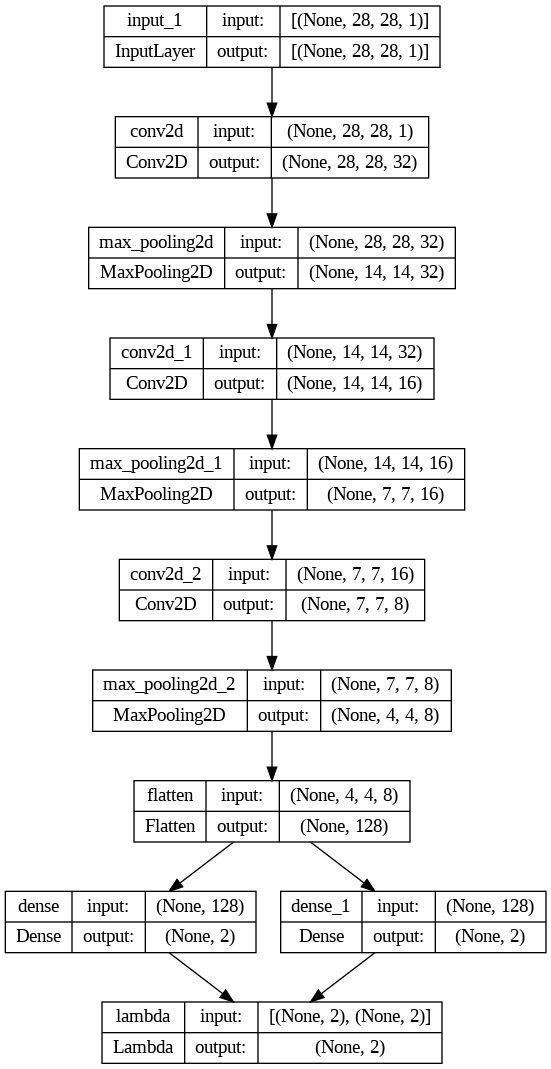

In [ ]:
from keras.utils import plot_model
plot_model(encoder, show_shapes=True)

In [ ]:
# Create decoder
## Aquí tu código ##

latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')

# 3 capas
x = layers.Dense(4 * 4 * 8, activation="relu")(latent_inputs)
x = layers.Reshape((4, 4, 8))(x)

x = layers.Conv2D(8, (3,3), activation = "relu", padding = "same")(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3,3), activation = "relu", padding = "same")(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3,3), activation = "relu", padding = "valid")(x)
x = layers.UpSampling2D((2, 2))(x)

outputs = layers.Conv2D(1, (3,3), activation = "sigmoid", padding = "same")(x)

decoder = keras.Model(latent_inputs, outputs, name='decoder')

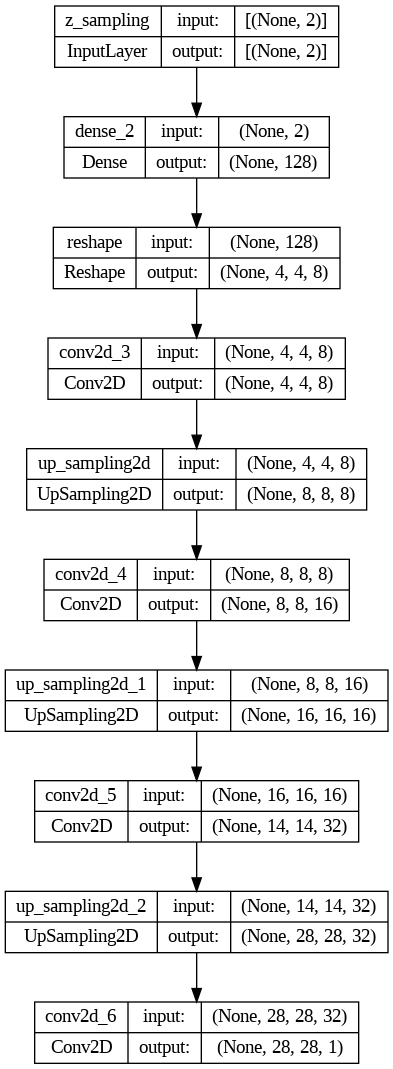

In [ ]:
from keras.utils import plot_model
plot_model(decoder, show_shapes=True)

In [ ]:
# instantiate VAE model
vae_outputs = decoder(encoder(input_img)[2])
vae = keras.Model(input_img, vae_outputs, name='vae_cnn')

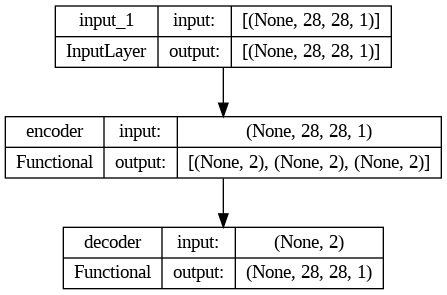

In [ ]:
from keras.utils import plot_model
plot_model(vae, show_shapes=True)

In [ ]:
reconstruction_loss = keras.losses.mse(K.flatten(input_img), K.flatten(vae_outputs))
reconstruction_loss *= original_dim

kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')

In [ ]:
vae.fit(x_train, x_train,
        epochs=30,
        batch_size=128,
        validation_data=(x_test, x_test))

Epoch 1/30
469/469 [==============================] - 26s 10ms/step - loss: 53.7337 - val_loss: 42.3462
Epoch 2/30
469/469 [==============================] - 4s 9ms/step - loss: 40.5454 - val_loss: 39.3063
Epoch 3/30
469/469 [==============================] - 4s 8ms/step - loss: 38.5380 - val_loss: 37.9025
Epoch 4/30
469/469 [==============================] - 4s 8ms/step - loss: 37.5914 - val_loss: 37.1048
Epoch 5/30
469/469 [==============================] - 4s 9ms/step - loss: 37.0190 - val_loss: 36.8605
Epoch 6/30
469/469 [==============================] - 4s 8ms/step - loss: 36.6454 - val_loss: 36.4381
Epoch 7/30
469/469 [==============================] - 4s 8ms/step - loss: 36.3130 - val_loss: 36.2765
Epoch 8/30
469/469 [==============================] - 4s 10ms/step - loss: 36.1074 - val_loss: 36.0506
Epoch 9/30
469/469 [==============================] - 4s 8ms/step - loss: 35.9210 - val_loss: 35.7716
Epoch 10/30
469/469 [==============================] - 4s 8ms/step - loss: 35.6

Y con esto, tenemos nuestro primer VAE Convolucional implementado.

Veamos las muestras que podemos generar:

1/1 [==============================] - 0s 16ms/step


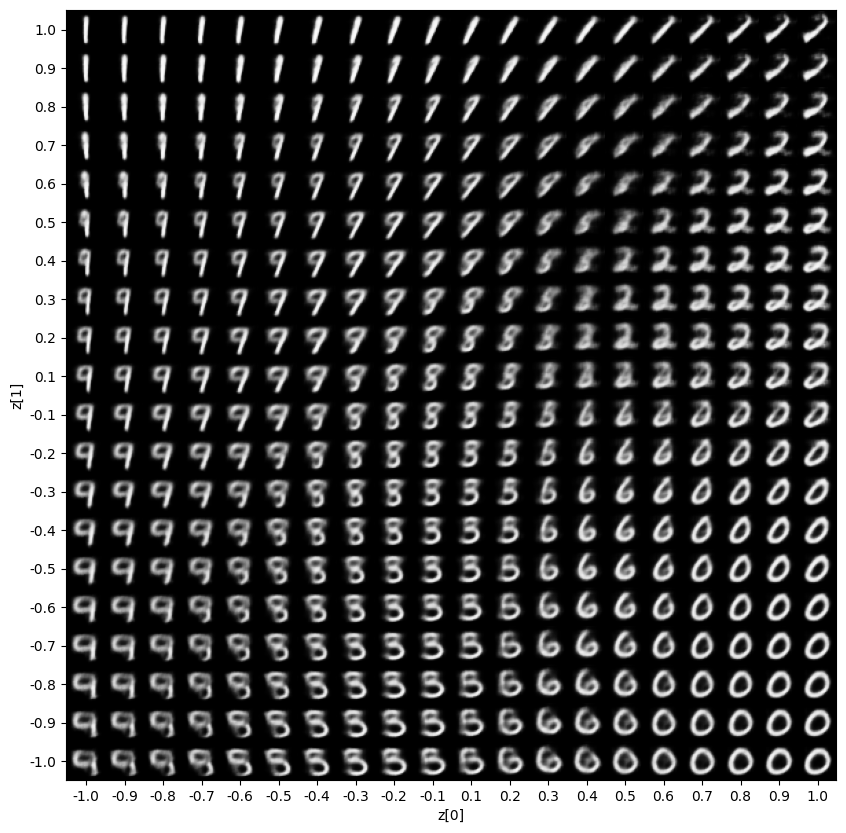

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(decoder, n=15, figsize=15):
    # display an n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

if (latent_dim==2):
  plot_latent_space(decoder, n=20, figsize=10)

1/1 [==============================] - 0s 166ms/step


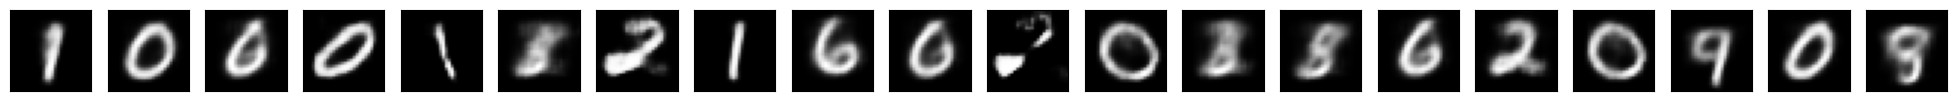

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generar muestras aleatorias en el espacio latente (por ejemplo, 20 muestras)
num_samples = 20
latent_samples = np.random.normal(0, 1, (num_samples, latent_dim))  # Generar muestras aleatorias en el espacio latente

# Utilizar el decodificador para obtener imágenes generadas
generated_images = decoder.predict(latent_samples)

# Mostrar las imágenes generadas
plt.figure(figsize=(25, 15))
for i in range(num_samples):
    ax = plt.subplot(2, num_samples, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Y el espacio latente, tanto del conjunto de entrenamiento como del de test.

1875/1875 [==============================] - 4s 2ms/step


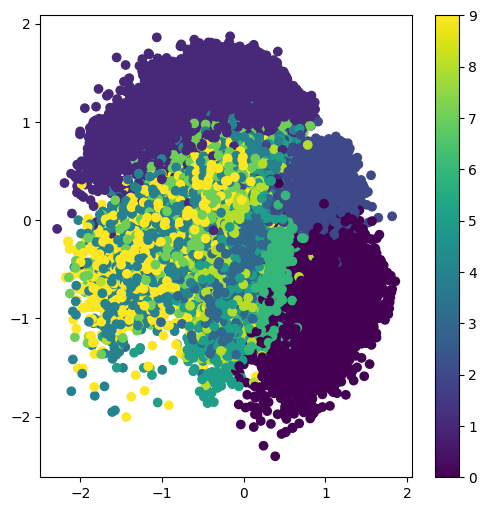

In [ ]:
import matplotlib.pyplot as plt

x_train_encoded = encoder.predict(x_train, batch_size=32)
x_train_encoded = np.asarray(x_train_encoded)

plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[2, :, 0], x_train_encoded[2, :, 1], c=y_train)
plt.colorbar()
plt.show()

313/313 [==============================] - 1s 2ms/step


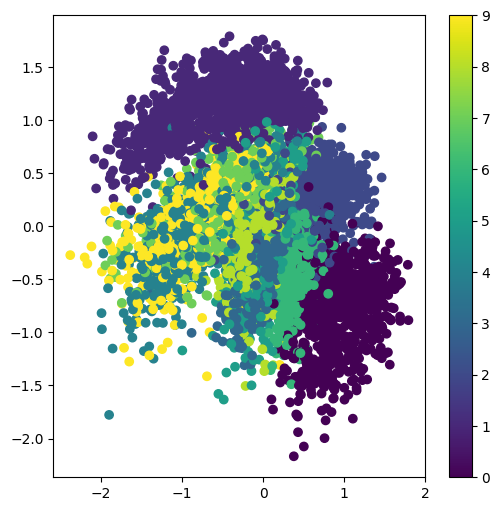

In [ ]:
import matplotlib.pyplot as plt

x_test_encoded = encoder.predict(x_test, batch_size=32)
x_test_encoded = np.asarray(x_test_encoded)

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[2, :, 0], x_test_encoded[2, :, 1], c=y_test)
plt.colorbar()
plt.show()

**Pregunta**: ¿Qué diferencias observas?

**Respuesta**: Bajo mi punto de vista diria que la distribución es similar, pero al haber menos datos la visualización del espacio latente en el test parece más dispersa y por lo tanto de peor calidad.

## Parte 2: Re-implementar el VAE convolucional empleando el GradientTape de TensorFlow y un *training loop* personalizado

La forma de programar con `GradientTape` y la creación de un bucle de entrenamiento personalizado en Keras ofrece ventajas significativas en comparación con la API secuencial y funcional de Keras en situaciones específicas. Algunas de estas ventajas son:

1. **Flexibilidad completa**: Con un bucle de entrenamiento personalizado tenéis un control total sobre cada paso del proceso de entrenamiento. Podéis implementar algoritmos de entrenamiento altamente personalizados y manejar situaciones que no son fáciles de abordar con modelos secuenciales o funcionales predefinidos, como por ejemplo, estructuras complejas.

2. **Investigación y experimentación**: Para investigadores y científicos que necesitan probar hipótesis, realizar experimentos y explorar nuevas arquitecturas de modelos, la programación personalizada con `GradientTape` brinda la flexibilidad necesaria. Podéis modificar el comportamiento del modelo y el proceso de entrenamiento en cada iteración.

3. **Regulación y pérdidas personalizadas**: Algunas aplicaciones requieren funciones de pérdida personalizadas o métodos de regularización no disponibles en la API secuencial o funcional. Con un bucle de entrenamiento personalizado, podéis implementar y ajustar estas funciones según sea necesario.

4. **Control absoluto de los gradientes**: `GradientTape` os permite acceder y modificar los gradientes en cada paso del entrenamiento, lo que puede ser esencial para aplicar técnicas de optimización avanzadas, como gradientes acoplados, cálculo de gradientes en funciones no diferenciables o personalización de reglas de actualización de pesos, por ejemplo.

5. **Análisis e inspección detallada**: Al escribir un bucle de entrenamiento personalizado, podéis realizar un seguimiento y análisis detallado de métricas e información en cada paso del entrenamiento, lo que es útil para el depuración, la monitorización y la recopilación de datos para la investigación.

Sin embargo, es importante destacar que las API secuenciales y funcionales de Keras son ideales para tareas comunes y suelen ser más fáciles de usar y más eficientes en términos de código.

La programación personalizada es más adecuada cuando se requiere un mayor control y adaptabilidad.

Para llevar a cabo esta implementación, deberéis completar los siguientes pasos:

- Definición de la arquitectura propia haciendo uso de `tf.keras.Model`
- Definición de la función de pérdidas
- Definición del comportamiento del modelo durante el *forward pass* (método `train_step` de la clase)
- Compilar `model.compile(...)` y entrenar `model.fit(...)` el modelo.

Estos son los pasos básicos.

Sin embargo, veremos que de esta forma todavía es `Keras` quien se encarga de "alimentar" el modelo. Esto es un paso intermedio entre la máxima personalización y las APIs funcionales y secuenciales que ofrece Keras. Todavía es posible personalizar más el proceso de entrenamiento, pero eso ya se lo dejo a quien le interese :)

Podéis leer sobre ello aquí: https://keras.io/guides/writing_a_training_loop_from_scratch/

### Definición de la arquitectura

In [ ]:
import tensorflow as tf

Primero crearemos una capa personalizada implementando el ["truco de reparametrización"](https://www.baeldung.com/cs/vae-reparameterization):

In [ ]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


Ahora la arquitectura en sí: el encoder, el decoder y sus comportamientos:

In [ ]:
import numpy as np
import tensorflow as tf


class ConvolutionalVAE(tf.keras.Model):

    def __init__(self, input_shape, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = self.get_encoder(input_shape)
        self.decoder = self.get_decoder(latent_dim)

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    # mediante esta porción de código definimos las métricas que queremos
    # vigilar durante el entrenamiento
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    # define the encoder
    def get_encoder(self, input_shape=(28, 28, 1), latent_dim=2):

        # encoder
        ## Aquí tu código ##

        encoder_inputs = tf.keras.Input(shape=((28, 28, 1)))

        x = layers.Conv2D(32, (3,3), activation = "relu", padding = "same")(encoder_inputs)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        x = layers.Conv2D(16, (3,3), activation = "relu", padding = "same")(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        x = layers.Conv2D(8, (3,3), activation = "relu", padding = "same")(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)

        flatten = layers.Flatten()(x)
        #print(flatten.shape)

        z_mean = layers.Dense(latent_dim)(flatten)
        z_log_var = layers.Dense(latent_dim)(flatten)
        #print(z_mean)

        z = Sampling()([z_mean, z_log_var])

        #print(z)

        encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

        #display(plot_model(encoder, show_shapes=True))

        return encoder

    # define the decoder
    def get_decoder(self, latent_dim):

        latent_inputs = tf.keras.layers.Input(shape=(latent_dim,), name='z_sampling')

        ## Aquí tu código ##

        x = layers.Dense(4 * 4 * 8, activation="relu")(latent_inputs)
        x = layers.Reshape((4, 4, 8))(x)

        x = layers.Conv2D(8, (3,3), activation = "relu", padding = "same")(x)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(16, (3,3), activation = "relu", padding = "same")(x)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(32, (3,3), activation = "relu", padding = "valid")(x)
        x = layers.UpSampling2D((2, 2))(x)

        decoder_outputs = layers.Conv2D(1, (3,3), activation = "sigmoid", padding = "same")(x)

        decoder = tf.keras.Model(latent_inputs, decoder_outputs, name='decoder')

        #display(plot_model(decoder, show_shapes=True))

        return decoder

    # aquí podemos definir lo que queremos que ocurra en cada iteración del
    # bucle de entrenamiento
    def train_step(self, data):

        # el GradientTape es el objeto que llevará un control de los gradientes
        # y el que permitirá que se actualicen los pesos
        with tf.GradientTape() as tape:

            # codificamos los datos de entrada
            z_mean, z_log_var, z = self.encoder(data)

            # reconstruimos los datos de entrada
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(keras.losses.mse(reconstruction, data), axis=(1, 2))
            )

            # calculamos las pérdidas KL
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        # obtenemos los gradientes de los parámetros (pesos y bias) a ajustar (entrenar)
        grads = tape.gradient(total_loss, self.trainable_weights)

        # optimizamos los pesos (los ajustamos, aquí es donde realmente se entrena la red)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # actualizamos las métricas
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


Ya tenemos la arquitectura definida, junto con las pérdidas y el `train_step`.

Ya solo nos queda alimentar el modelo y entrenarlo, y comprobar los resultados.

Vamos a preparar los datos del MNIST.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

Ahora instanciamos el modelo:

In [ ]:
input_shape = (28, 28, 1)
latent_dims = 2
vae = ConvolutionalVAE(input_shape, latent_dims)

Lo compilamos y por último, lo entrenamos.

Fijaos en que en esta ocasión, como tenemos control sobre el *training loop*, le introducimos solo los datos `x_train`, ya que en el `train_step` solo usaremos esos datos (como ambas entradas a la función de pérdidas de reconstrucción).

In [ ]:
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 7s 7ms/step - loss: 77.0009 - reconstruction_loss: 56.4825 - kl_loss: 1.5449
Epoch 2/30
469/469 [==============================] - 3s 7ms/step - loss: 44.9844 - reconstruction_loss: 41.2922 - kl_loss: 3.0201
Epoch 3/30
469/469 [==============================] - 4s 8ms/step - loss: 43.1313 - reconstruction_loss: 39.4489 - kl_loss: 3.3787
Epoch 4/30
469/469 [==============================] - 3s 7ms/step - loss: 42.2711 - reconstruction_loss: 38.5005 - kl_loss: 3.5634
Epoch 5/30
469/469 [==============================] - 3s 7ms/step - loss: 41.6836 - reconstruction_loss: 37.8319 - kl_loss: 3.6968
Epoch 6/30
469/469 [==============================] - 4s 8ms/step - loss: 41.1630 - reconstruction_loss: 37.3168 - kl_loss: 3.8141
Epoch 7/30
469/469 [==============================] - 3s 7ms/step - loss: 40.9832 - reconstruction_loss: 36.9356 - kl_loss: 3.8897
Epoch 8/30
469/469 [==============================] - 3s 7ms/step - loss: 40.5862 -

Vamos a visualizar un grid de imágenes generadas con nuestro VAE para ver qué tal funciona:

1/1 [==============================] - 0s 22ms/step


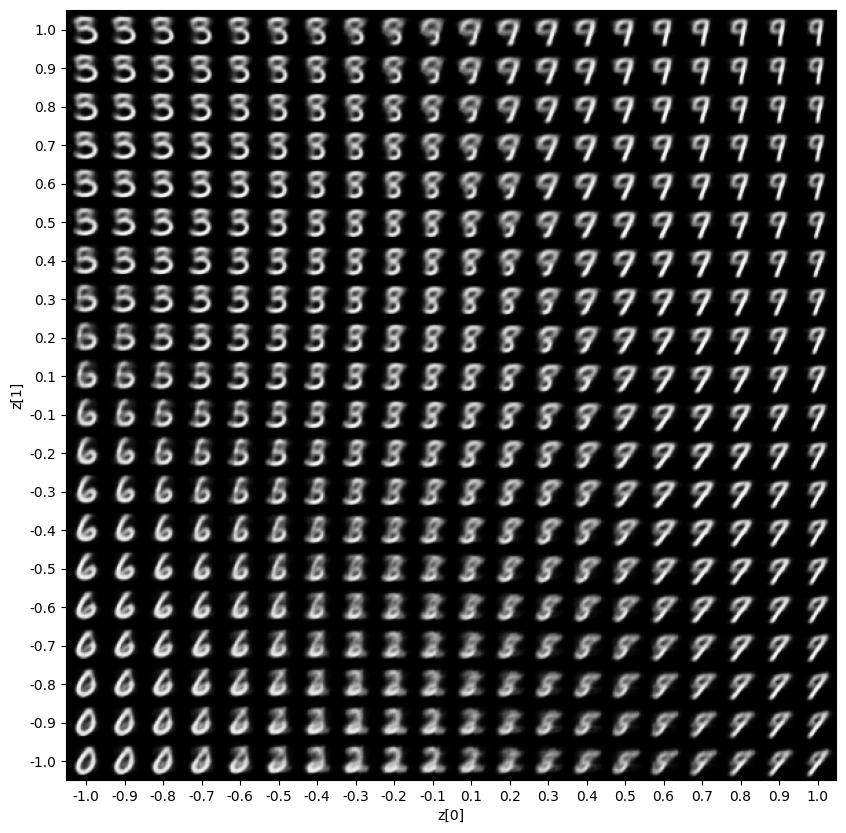

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=15, figsize=15):
    # display an n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae, n=20, figsize=10)

Y ahora lo mismo pero con los códigos latentes, tanto de train como de test.

1875/1875 [==============================] - 3s 2ms/step


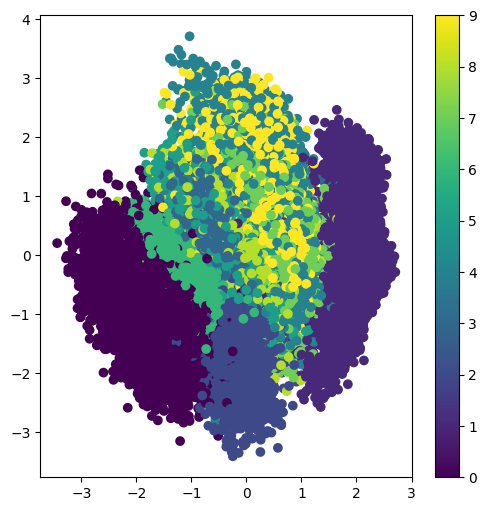

In [ ]:
import matplotlib.pyplot as plt

x_train_encoded = vae.encoder.predict(x_train, batch_size=32)
x_train_encoded = np.asarray(x_train_encoded)

plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[0, :, 0], x_train_encoded[0, :, 1], c=y_train)
plt.colorbar()
plt.show()

313/313 [==============================] - 1s 2ms/step


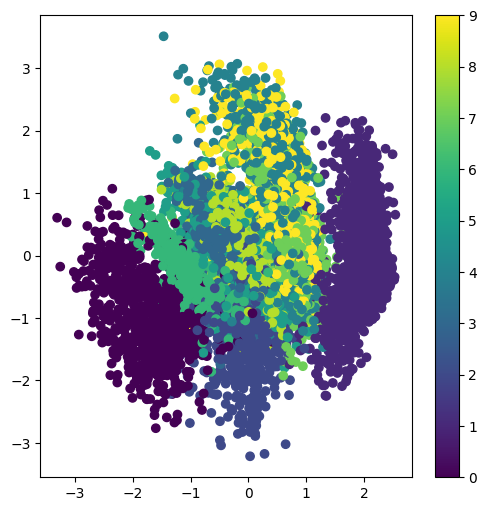

In [ ]:
import matplotlib.pyplot as plt

x_test_encoded = vae.encoder.predict(x_test, batch_size=32)
x_test_encoded = np.asarray(x_test_encoded)

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[0, :, 0], x_test_encoded[0, :, 1], c=y_test)
plt.colorbar()
plt.show()